In [2]:
# import algos and graphs
import sys
import os
import networkx as nx
import matplotlib.pyplot as plt
import gzip
import random
import time
import requests
import urllib3
import csv
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# Add parent directory to path so algorithms can be imported
sys.path.append(os.path.abspath("../algorithms"))

# Import algorithms
from greedy import find_maximum_clique_from_dict
from local_search import local_search
from randomized import randomized_max_clique
from local_random import local_random_clique
from simulated_annealing import simulated_annealing_with_restarts
from bron_kerbosch import bron_kerbosch_with_pivot, bron_kerbosch_basic

print("All algorithms imported successfully.")


All algorithms imported successfully.


In [5]:
# --- CSV Logging Setup ---
csv_path = "../results/experiment_log.csv"

def initialize_csv(path):
    """Create CSV file with headers if it doesn't exist."""
    file_exists = os.path.isfile(path)
    if not file_exists:
        with open(path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(['run_number', 'graph_name', 'num_vertices', 'algorithm', 'clique_size', 'runtime'])
        print(f"✅ Created new log file: {path}")
    return path

def get_next_run_number(path):
    """Get the next run number by reading the CSV."""
    if not os.path.isfile(path):
        return 1
    
    with open(path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f)
        rows = list(reader)
        
        # If file is empty or only has header
        if len(rows) <= 1:
            return 1
        
        # Get the last row's run number
        try:
            return int(rows[-1][0]) + 1
        except (ValueError, IndexError):
            return 1
        
def log_result(path, run_num, type, graph_name, num_vertices, algorithm, clique_size, runtime):
    """Append a result to the CSV log."""
    with open(path, 'a', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([run_num, type, graph_name, num_vertices, algorithm, clique_size, f"{runtime:.6f}"])
    print(f"📝 Logged: Run {run_num} | {type} | {algorithm} | Clique size: {clique_size} | Runtime: {runtime:.6f}s")

# Initialize CSV and get run number
initialize_csv(csv_path)
run_number = get_next_run_number(csv_path)

print(f"📊 Current run number: {run_number}\n")

📊 Current run number: 30



In [9]:
# import a graph

# --- Step 1: Helper to load .adj file ---
def load_adj_file(path):
    """
    Loads a graph stored in adjacency list format (.adj) and
    returns a dictionary {node: set(neighbors)} suitable for Bron–Kerbosch.
    """
    adj_dict = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if ":" not in line:
                continue
            node, neighbors = line.strip().split(":", 1)
            node = node.strip()
            neighbor_set = set(neighbors.strip().split()) if neighbors.strip() else set()
            adj_dict[node] = neighbor_set
    return adj_dict

# --- Step 2: Load student cooperation graph ---
small_graph_dir = "../data/small_graphs"
all_adj_files = [f for f in os.listdir(small_graph_dir) if f.endswith(".adj")]

if not all_adj_files:
    raise FileNotFoundError(f"No .adj files found in {small_graph_dir}")

chosen_file = random.choice(all_adj_files)
adj_path = os.path.join(small_graph_dir, chosen_file)

print(f"📂 Loading graph from: {adj_path}")
G_dict = load_adj_file(adj_path)
print(f"✅ Graph loaded: {len(G_dict)} vertices ({chosen_file})")

📂 Loading graph from: ../data/small_graphs/les_miserables.adj
✅ Graph loaded: 77 vertices (les_miserables.adj)



🔍 Running Greedy algorithm...

=== Greedy ===
Max Clique Nodes: ['36', '20', '27', '35', '1', '40']
Size: 6
Runtime: 0.0015 sec

📝 Logged: Run 12 | small | greedy | Clique size: 6 | Runtime: 0.001480s


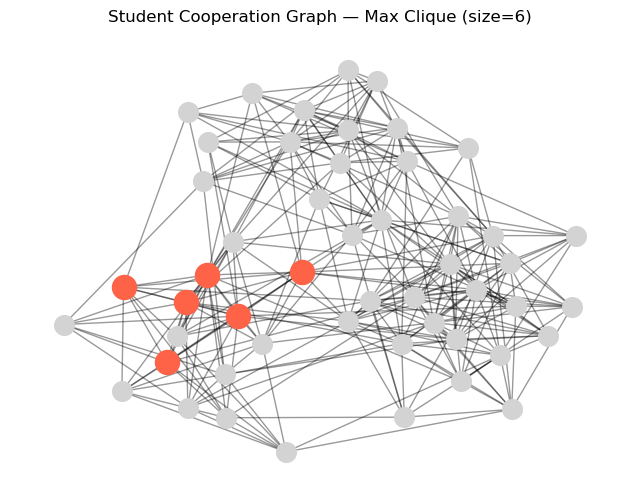

In [106]:
# Greedy
print("\n🔍 Running Greedy algorithm...\n")

start = time.time()
max_clique, runtime = find_maximum_clique_from_dict(G_dict)
end = time.time()

print("=== Greedy ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

log_result(csv_path, run_number, "small", chosen_file, len(G_dict), "greedy", len(max_clique), (end-start))

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Local Search algorithm...

=== Local Search ===
Max Clique Nodes: {'40', '36', '20', '27', '1', '35'}
Size: 6
Runtime: 0.0012 sec

📝 Logged: Run 12 | small | local_search | Clique size: 6 | Runtime: 0.001243s


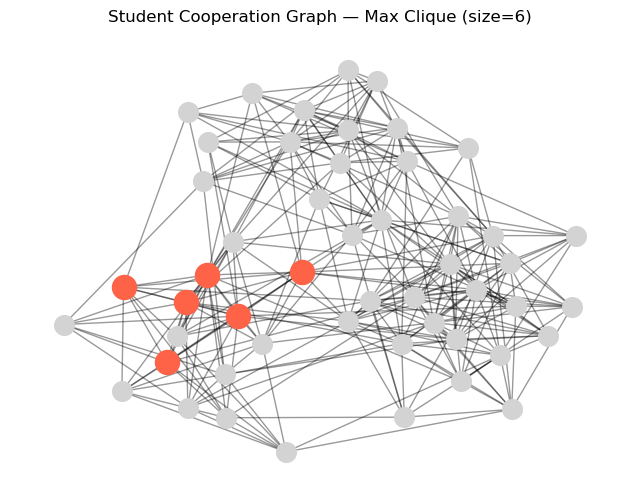

In [107]:
# Local search
print("\n🔍 Running Local Search algorithm...\n")

start = time.time()
max_clique, runtime = local_search(G_dict)
end = time.time()

print("=== Local Search ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

log_result(csv_path, run_number, "small", chosen_file, len(G_dict), "local_search", len(max_clique), (end-start))

# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Randomized algorithm...

=== Randomized ===
Max Clique Nodes: ['11', '36', '20', '42', '35']
Size: 5
Runtime: 0.0001 sec

📝 Logged: Run 12 | small | randomized | Clique size: 5 | Runtime: 0.000116s


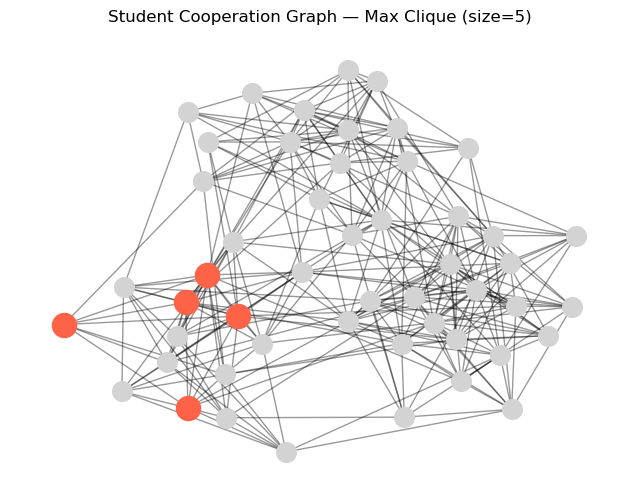

In [108]:
# randomized
print("\n🔍 Running Randomized algorithm...\n")

start = time.time()
size, max_clique, _ = randomized_max_clique(G_dict, restarts=10)
end = time.time()

print("=== Randomized ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

log_result(csv_path, run_number, "small", chosen_file, len(G_dict), "randomized", len(max_clique), (end-start))

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Local Random Search algorithm...

=== Local Random Search ===
Max Clique Nodes: {'20', '40', '27', '1', '36', '35'}
Size: 6
Runtime: 0.0108 sec

📝 Logged: Run 12 | small | local_random | Clique size: 6 | Runtime: 0.010834s


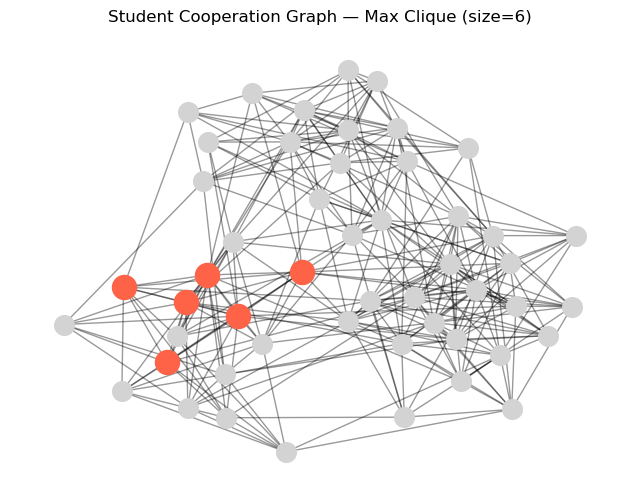

In [109]:
# Local random search
print("\n🔍 Running Local Random Search algorithm...\n")

start = time.time()
max_clique, runtime = local_random_clique(G_dict)
end = time.time()

print("=== Local Random Search ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

log_result(csv_path, run_number, "small", chosen_file, len(G_dict), "local_random", len(max_clique), (end-start))

# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Simulated Annealing algorithm...

=== Simulated Annealing ===
Max Clique Nodes: {'20', '27', '36', '4', '35'}
Size: 5
Runtime: 0.1998 sec

📝 Logged: Run 12 | small | simulated_annealing | Clique size: 5 | Runtime: 0.199827s


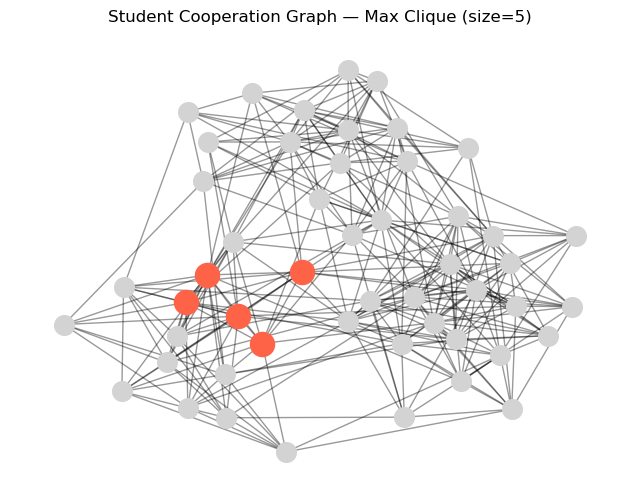

In [110]:
# Simulated Annealing
print("\n🔍 Running Simulated Annealing algorithm...\n")

start = time.time()
max_clique, runtime_sa, _ = simulated_annealing_with_restarts(
    G_dict, # Pass the loaded dictionary graph directly
    initial_temp=1.0, 
    cooling_rate=0.9999,
    max_iterations=10000, 
    num_restarts=5,
    verbose=False
)
end = time.time()

print("=== Simulated Annealing ===")
print(f"Max Clique Nodes: {max_clique}")
print(f"Size: {len(max_clique)}")
print(f"Runtime: {end - start:.4f} sec\n")

log_result(csv_path, run_number, "small", chosen_file, len(G_dict), "simulated_annealing", len(max_clique), (end-start))

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique)})")
plt.axis("off")
plt.show()


🔍 Running Bron–Kerbosch algorithms...

=== Bron–Kerbosch (With Pivoting) ===
Max Clique Nodes: {'59', '64', '65', '61', '58', '48', '60', '63', '66', '62'}
Size: 10
Runtime: 0.0006 sec

=== Bron–Kerbosch (Basic) ===
Max Clique Nodes: {'59', '64', '55', '65', '61', '58', '48', '63', '57', '62'}
Size: 10
Runtime: 0.0023 sec

📝 Logged: Run 30 | small | bron_kerbosch | Clique size: 10 | Runtime: 0.002290s


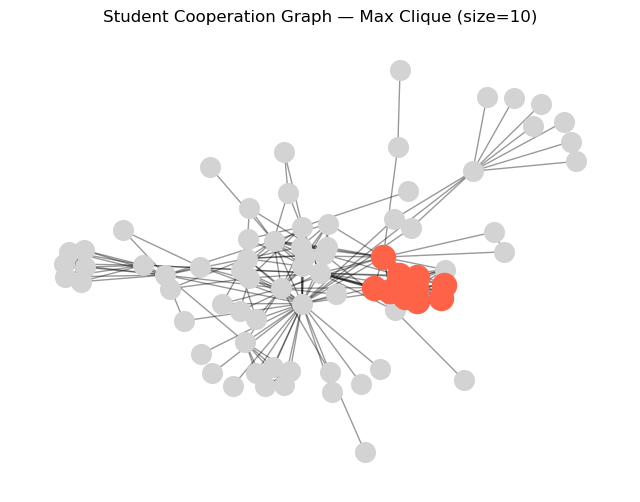

In [10]:
# --- Step 3: Run Bron–Kerbosch (pivoting & basic) ---
print("\n🔍 Running Bron–Kerbosch algorithms...\n")

# With pivot
start_pivot = time.time()
max_clique_pivot, runtime_pivot = bron_kerbosch_with_pivot(G_dict)
end_pivot = time.time()

# Basic
start_basic = time.time()
max_clique_basic, runtime_basic = bron_kerbosch_basic(G_dict)
end_basic = time.time()

# --- Step 4: Display Results ---
print("=== Bron–Kerbosch (With Pivoting) ===")
print(f"Max Clique Nodes: {max_clique_pivot}")
print(f"Size: {len(max_clique_pivot)}")
print(f"Runtime: {end_pivot - start_pivot:.4f} sec\n")

print("=== Bron–Kerbosch (Basic) ===")
print(f"Max Clique Nodes: {max_clique_basic}")
print(f"Size: {len(max_clique_basic)}")
print(f"Runtime: {end_basic - start_basic:.4f} sec\n")

log_result(csv_path, run_number, "small", chosen_file, len(G_dict), "bron_kerbosch", len(max_clique_basic), (end_basic-start_basic))

# --- Step 5: Visualization (optional, small graphs only) ---
# Since student-cooperation has only ~185 nodes, visualization is possible
G_nx = nx.Graph()
for node, nbrs in G_dict.items():
    for nbr in nbrs:
        G_nx.add_edge(node, nbr)

pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(8, 6))
nx.draw_networkx_nodes(G_nx, pos, node_color="lightgray", node_size=200)
nx.draw_networkx_edges(G_nx, pos, alpha=0.4)
nx.draw_networkx_nodes(G_nx, pos, nodelist=max_clique_pivot, node_color="tomato", node_size=300)
plt.title(f"Student Cooperation Graph — Max Clique (size={len(max_clique_pivot)})")
plt.axis("off")
plt.show()
